# Applying the trained classifier to a large datasets

- Workshop: **Tutorial: High performance computing with Python and RS-DAT, EO summer school 2025**

- Date: September 3, 2025


In this notebook, we apply a random forest classifier that we have trained in [the previous notebook](./step1_train_on_cutout.ipynb) on a small cutout, to a large Sentinel-2 mosaic, to predict a water mask across the entire Area of Interest (AoI). We use [Dask](https://www.dask.org/) to distribute the prediction process across multiple chunks of the image, which allows us to handle large images efficiently.

In [1]:
from pathlib import Path

import dask
import dask.array as da
import geopandas
import joblib  # to save and load the model
import rioxarray
import shapely
import xarray as xr

from dask.distributed import Client, LocalCluster, Lock
from matplotlib import pyplot as plt

---
## Data used in this notebook¶

The data used in this workshop can be found on Zenodo ([link](https://zenodo.org/records/16941613)):

In [2]:
# Uncomment the following line to retrive the dataset
# !wget https://zenodo.org/api/records/16941613/files-archive

Not that on the [Spider](https://doc.spider.surfsara.nl/en/latest/) platform, which we use for demonstraiton, the data is already available under the following path:

In [3]:
data_dir = Path("/project/remotesensing/Data/eo-summer-school")

The input data include:
- `sentinel2_rgb_mosaic.tif`: Sentinel-2 RGB mosaic representing the area of interest at 10 m resolution.
- `waterbody_labels.gpkg`: manually-created polygons with label values, where label 1 represents water bodies and label 0 represents non-water bodies.

In [a previous notebook](./step1_train_on_cutout.ipynb), we have used the label data to train the binary classifier. In this notebook, we apply the trained model to the full extent of the Sentinel-2 mosaic.

---

## Overview of the Area of Interest (AoI)

First, let's take another look at the AoI by visualizing the Cloud-Optimized GeoTIFF (COG).

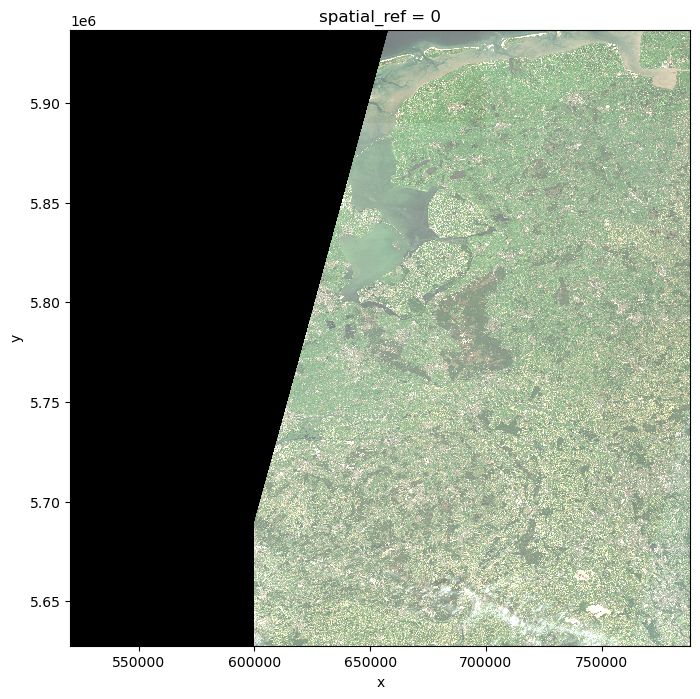

In [4]:
# Load and visualize an overview of the full RGB
path_rgb = data_dir / "sentinel2_rgb_mosaic.tif"
rgb = rioxarray.open_rasterio(path_rgb, overview_level=1)
fig, ax = plt.subplots(figsize=(8, 8))
rgb.plot.imshow(ax=ax, robust=True)

## Loading the dataset and the trained model

In the following steps, we will load the full RGB image chunk-wise. Depending on the computation infrastructure, we can adjust the chunk size accordingly. With the `chunks` input argument in `rioxarray.open_rasterio`, we can "lazily" load the large image, i.e. create a task graph for loading the data in chunks. The image loading will only take place when we actually need the data!

In [5]:
# Configure chunksize for the later processing
CHUNKSIZE = 4096

# Lazy loading of the RGB data, chunked and no locks
rgb = rioxarray.open_rasterio(path_rgb, chunks={"band": -1, "x": CHUNKSIZE, "y": CHUNKSIZE}, lock=False)
rgb

<xarray.DataArray (band: 3, y: 30917, x: 26763)> Size: 5GB
dask.array<open_rasterio-cf54d264b146863bcebc6bb6e2a3db45<this-array>, shape=(3, 30917, 26763), dtype=uint16, chunksize=(3, 4096, 4096), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 214kB 5.206e+05 5.206e+05 ... 7.882e+05 7.882e+05
  * y            (y) float64 247kB 5.937e+06 5.937e+06 ... 5.628e+06 5.628e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

We then load the trained classifier from the previous step:

In [6]:
classifier = joblib.load('binary_classifier_waterbody.pkl')

## Parallelizing inference on large datasets

We setup a Dask cluster, i.e. a pool of "workers" connected to a "scheduler" that distribute and orchestrate the tasks of the graph. When running locally, one can set up a `LocalCluster` to distribute tasks to threads and/or processes. On a HPC infrastructure running SLURM, one can use Dask Jobqueue's `SLURMCluster` to start a Dask cluster backed by the SLURM scheduler, which provides resources upon request. 

 One can inspect the process the status of the cluster through the Dask dashboard.

In [7]:
# SETUP A DISTRIBUTED CLUSTER HERE ...

In [8]:
from dask.distributed import Client

client = Client("tcp://10.0.1.40:38005")
client

<Client: 'tcp://10.0.1.40:38005' processes=2 threads=8, memory=64.00 GiB>

In [9]:
# ... OR USE LOCAL CLUSTER
# cluster = LocalCluster()
# client = Client(cluster)
# client

Now we will apply the trained classifier to the full image in chunks. Many Python libraries, such as `numpy` functions, can interface to Dask arrays, in which case we can directly pass Dask arrays as input. 

However, this is not the case for the `predict` function of `sklearn` classifiers. Below we demonstrate how to use xarray's `apply_ufunc()` function to "map" the classifier predict function to each chunk of the image. In the section commented out below, we show an alternative approach using xarray's `map_blocks()`, which is more suitable for functions that consume xarray objects.

In [10]:
def predict_chunk(x):
    """
    Run inference for one chunk of the dataset.

    Parameters
    ----------
    x : np.ndarray
        Input raster bands, with shape (NY, NX, 3)

    Returns
    -------
    np.ndarray
        Predictions, with shape (NY, NX)
    """
    *chunk_shape, _ = x.shape
    x_reshaped = x.reshape(-1, 3)
    y = classifier.predict(x_reshaped) # binary prediction
    return y.reshape(chunk_shape)

# Map the `classifier.predict` to all chunks of the dataset
predictions = xr.apply_ufunc(
    predict_chunk,
    rgb,
    exclude_dims={"band"},
    input_core_dims=[["band"]],
    dask="parallelized",
    output_dtypes=["uint16"],
)
predictions = predictions.rio.write_crs(rgb.rio.crs)  # Make sure CRS is kept

In [11]:
# # Below is an example predict with xarray.map_blocks
# # Prediction on each band
# def predict_chunk(chunk, classifier):
#     """Predict on a chunk of data"""
#     # chunk is now an xarray DataArray
#     original_shape = chunk.shape
#     reshaped = chunk.data.reshape((chunk.shape[0], -1)).T

#     # Predict probabilities
#     pred = classifier.predict(reshaped)

#     # Reshape back to spatial dimensions with probability classes
#     result = pred.T.reshape((1, original_shape[1], original_shape[2]))

#     # Return as xarray DataArray with proper coordinates
#     return xr.DataArray(
#         result,
#         dims=['band', 'y', 'x'],
#         coords={
#             'band': [0],
#             'y': chunk['y'],
#             'x': chunk['x']
#         }
#     )

# # Apply prediction function using xarray.map_blocks
# predictions = xr.map_blocks(
#     predict_chunk,
#     rgb,
#     args=[classifier],
#     template=xr.DataArray(
#         da.zeros((1, rgb.sizes['y'], rgb.sizes['x']), chunks=(-1, CHUNKSIZE, CHUNKSIZE)),
#         dims=['band', 'y', 'x'],
#         coords={
#             'band': [0],
#             'y': rgb['y'],
#             'x': rgb['x']
#         }
#     )
# )

# predictions

One can also visualize the task graph of the prediction process using Dask's `visualize` function (note that this requires the `graphviz` package to be installed in the environment).

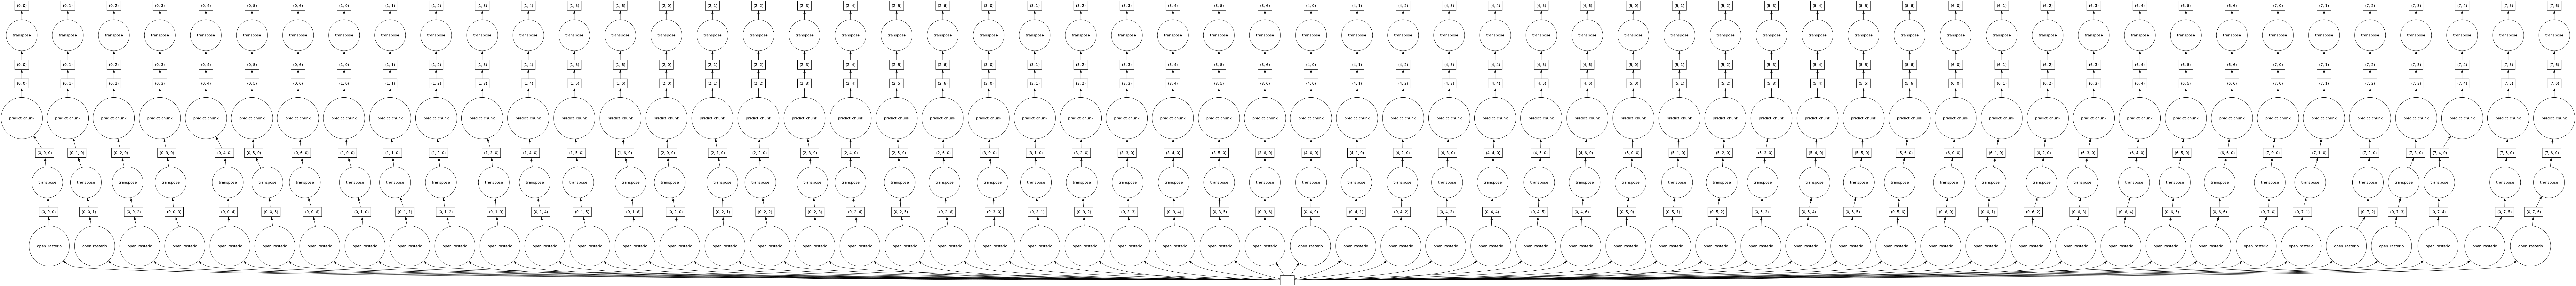

In [12]:
dask.visualize(predictions)

## Save predictions

Now the `predictions` variable has not been computed yet - it still consists of a task graph represented by a Dask array. One can call its `.compute()` method to evaluate the result, and collect it in memory - if the "client" memory capacity allows for it. 

Alternatively, one can instruct the Dask cluster to save the output directly to a (set of) file(s). This is desirable for datasets that do not fit the memory of a single machine.

In this example, we will save the predictions to a tiled GeoTIFF file (writing a COG in parallel is tricky). Another suitable file format for (multi-dimensional) array data is [Zarr](https://zarr.dev/), which by was designed for parallel read/write.

In [13]:
output_path = Path.home() / "predictions_waterbody.tif"

In [14]:
# Save to a tiled GeoTIFF
predictions.rio.to_raster(
    output_path,
    tiled=True,
    BLOCKXSIZE=CHUNKSIZE,
    BLOCKYSIZE=CHUNKSIZE,
    COMPRESS="LZW",
    lock=Lock("rio")
)

In [15]:
# For large datasets and multiple dimensions, Zarr is a good alternative to (CO)GeoTIFF
# predictions.to_zarr(
#     "predictions_waterbody_full.zarr",
#     mode="w",
# )

## Visualize mask

Now we can visualize the computed predictions - let's zoom in into a different area.

In [16]:
# Load the saved predictions with overview level
predictions_loaded = rioxarray.open_rasterio(output_path, chunks="auto")
predictions_loaded

<xarray.DataArray (band: 1, y: 30917, x: 26763)> Size: 2GB
dask.array<open_rasterio-9a441953bcef9d71a097c12d28f63c2b<this-array>, shape=(1, 30917, 26763), dtype=uint16, chunksize=(1, 8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 214kB 5.206e+05 5.206e+05 ... 7.882e+05 7.882e+05
  * y            (y) float64 247kB 5.937e+06 5.937e+06 ... 5.628e+06 5.628e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [17]:
# Define bounding box
bbox = geopandas.GeoSeries(
        shapely.box(5.64, 52.41, 6.26, 52.79), # xmin, ymin, xmax, ymax
        crs="EPSG:4326") \
    .to_crs(predictions_loaded.rio.crs) \
    .total_bounds

In [18]:
predictions_loaded_cutout = predictions_loaded.rio.clip_box(*bbox)
rgb_cutout = rgb.rio.clip_box(*bbox)

(np.float64(678012.9341663752),
 np.float64(721719.869410665),
 np.float64(5809920.161439333),
 np.float64(5853892.782441879))

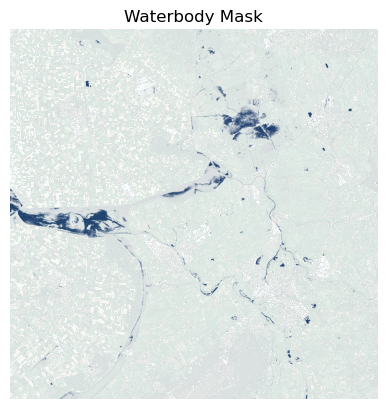

In [19]:
# Visualize the cutout predictions
fig, ax = plt.subplots()
rgb_cutout.plot.imshow(ax=ax, alpha=0.6, robust=True)
extent = bbox[[0, 2, 1, 3]] # xmin, xmax, ymin, ymax
ax.imshow(predictions_loaded_cutout.data.squeeze(), cmap='Blues', alpha=0.8, extent=extent)
ax.set_title('Waterbody Mask')
ax.axis('off')